In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pyeit.eit.bp as bp
import pyeit.eit.greit as greit
import pyeit.eit.jac as jac
import pyeit.eit.protocol as protocol
from sciopy import plot_mesh
from pyeit.mesh.shape import thorax
from IPython.display import Image
import pyeit.mesh as mesh
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from PIL import Image
from pyeit.eit.interp2d import sim2pts
from tqdm import tqdm
from sciopy import norm_data
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from support import GREIT_sample, show_mesh
from tensorflow import GradientTape, exp, keras, reduce_mean, reduce_sum, shape, square
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (
    LSTM,
    Activation,
    Add,
    BatchNormalization,
    Bidirectional,
    Concatenate,
    Conv1D,
    Conv2D,
    ConvLSTM1D,
    Cropping1D,
    Cropping2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    Lambda,
    MaxPooling1D,
    Normalization,
    Reshape,
    ZeroPadding1D,
)
from tensorflow.keras.losses import Huber, binary_crossentropy, mse
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model

2023-11-01 13:26:26.925196: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


In [2]:
from IPython.display import IFrame
IFrame("../images/LSTM_VAE_V3.pdf", width=600, height=400)

## Data
![SegmentLocal](breathing.gif "segment")

In [3]:
tmp = np.load("../data_thorax/h0=0.025_n_el=16_r_min=0.1_r_max=0.4_dist_exc=8_step_meas=4noise=True/sample_000000.npz", allow_pickle=True)
tmp.files

['anomaly',
 'perm_array',
 'n_el',
 'h0',
 'v_empty',
 'v_obj',
 'dist_exc',
 'step_meas']

In [16]:
# create empty mesh:
mesh_obj = mesh.create(tmp["n_el"], h0=tmp["h0"], fd=thorax)

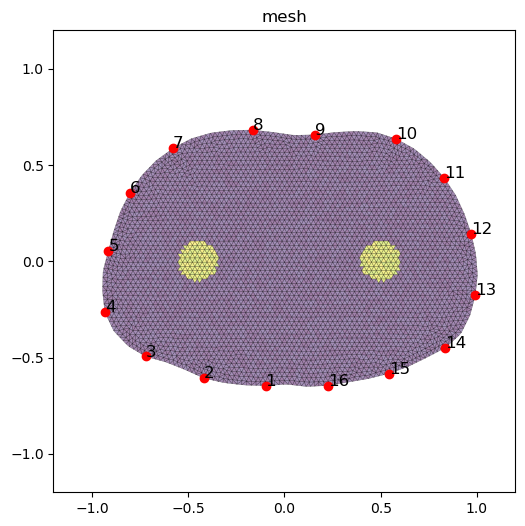

In [20]:
mesh_obj.perm = tmp["perm_array"]
plot_mesh(mesh_obj)

In [3]:
l_path = "../data_thorax/h0=0.025_n_el=16_r_min=0.1_r_max=0.4_dist_exc=8_step_meas=4noise=True/"
V_all = list()
radii = list()

for ele in tqdm(np.sort(os.listdir(l_path))):
    tmp_l = np.load(l_path +ele, allow_pickle=True)
    V_all.append(tmp_l["v_obj"])
    radii.append(tmp_l["anomaly"][0].r)
    
V_all = np.array(V_all)
radii = np.array(radii)

100%|██████████| 10000/10000 [00:25<00:00, 385.42it/s]


In [4]:
print(V_all.shape, radii.shape)

(10000, 192) (10000,)


## Build VAE

In [5]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
latent_dim = 4

encoder_inputs = keras.Input(shape=(192,))

x = layers.Reshape((192,1))(encoder_inputs)
x = layers.Conv1D(64, activation="relu", kernel_size=3,strides=2, padding="same")(x)
x = layers.Conv1D(32, activation="relu", kernel_size=3,strides=2, padding="same")(x)
x = layers.Conv1D(16, activation="relu", kernel_size=3,strides=2, padding="same")(x)
x = layers.Conv1D(8, activation="relu", kernel_size=3,strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling(name="z")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192)]        0           []                               
                                                                                                  
 reshape (Reshape)              (None, 192, 1)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 96, 64)       256         ['reshape[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 48, 32)       6176        ['conv1d[0][0]']                 
                                                                                            

2023-11-01 13:27:04.342549: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46672 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-11-01 13:27:04.344365: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46672 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


In [7]:
# Definiere den Decoder
latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(96, activation="relu")(x)
x = layers.Reshape((12,8))(x)
x = layers.Conv1DTranspose(16, activation="relu", kernel_size=3, strides=2, padding="same")(x)
x = layers.Conv1DTranspose(32, activation="relu", kernel_size=3, strides=2, padding="same")(x)
x = layers.Conv1DTranspose(64, activation="relu", kernel_size=3, strides=2, padding="same")(x)
x = layers.Conv1DTranspose(128, activation="relu", kernel_size=3, strides=2, padding="same")(x)
x = layers.Conv1DTranspose(1, activation="relu", kernel_size=1, strides=1, padding="same")(x)

decoder_outputs = layers.Flatten()(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 4)]               0         
                                                                 
 dense_1 (Dense)             (None, 16)                80        
                                                                 
 dense_2 (Dense)             (None, 96)                1632      
                                                                 
 reshape_1 (Reshape)         (None, 12, 8)             0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 24, 16)           400       
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 48, 32)           1568      
 ranspose)                                                 

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # mse_loss = tf.keras.losses.mean_squared_error(data, reconstruction)
            mse_loss = tf.keras.losses.mean_squared_error(data, reconstruction)
            reconstruction_loss = tf.reduce_mean(mse_loss)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [9]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [10]:
#V_all = np.expand_dims(V_all,2)

V_vae_train, V_vae_test = train_test_split(
    V_all, test_size=0.05, shuffle=True, random_state=52
)

In [11]:
print(V_vae_train.shape, V_vae_test.shape)
print(np.min(V_all), np.max(V_all))

(9500, 192) (500, 192)
-0.6822878622665547 0.6822878622665547


In [12]:
history = vae.fit(V_vae_train, epochs=25, batch_size=64)

Epoch 1/25


2023-11-01 13:27:08.486150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-11-01 13:27:09.438402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-01 13:27:09.697586: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55dc15ecfb60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-01 13:27:09.697647: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-01 13:27:09.697658: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-01 13:27:09.722174: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-01 13:27:09.92618

149/149 [==============================] - 9s 11ms/step - loss: 0.0542 - reconstruction_loss: 0.0451 - kl_loss: 7.1938e-06
Epoch 2/25
149/149 [==============================] - 2s 10ms/step - loss: 0.0390 - reconstruction_loss: 0.0388 - kl_loss: 7.5004e-08
Epoch 3/25
149/149 [==============================] - 2s 10ms/step - loss: 0.0390 - reconstruction_loss: 0.0387 - kl_loss: 4.2491e-08
Epoch 4/25
149/149 [==============================] - 2s 10ms/step - loss: 0.0387 - reconstruction_loss: 0.0386 - kl_loss: 4.2414e-08
Epoch 5/25
149/149 [==============================] - 2s 10ms/step - loss: 0.0388 - reconstruction_loss: 0.0386 - kl_loss: 4.4572e-08
Epoch 6/25
149/149 [==============================] - 2s 10ms/step - loss: 0.0383 - reconstruction_loss: 0.0387 - kl_loss: 3.7573e-08
Epoch 7/25
149/149 [==============================] - 2s 10ms/step - loss: 0.0386 - reconstruction_loss: 0.0386 - kl_loss: 3.9163e-08
Epoch 8/25
149/149 [==============================] - 2s 10ms/step - loss

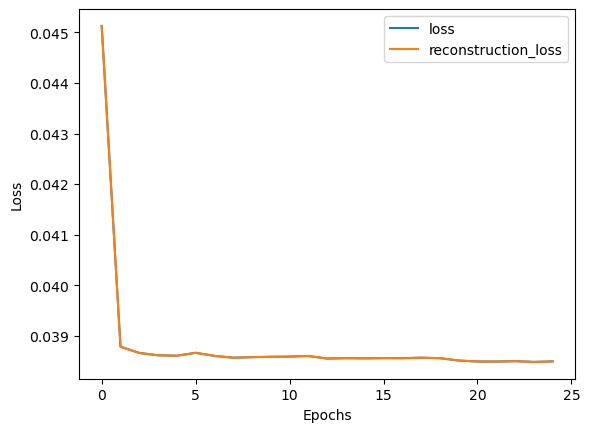

In [14]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["reconstruction_loss"], label="reconstruction_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
z_mean, _, _ = vae.encoder.predict(V_all)

313/313 [==============================] - 1s 2ms/step


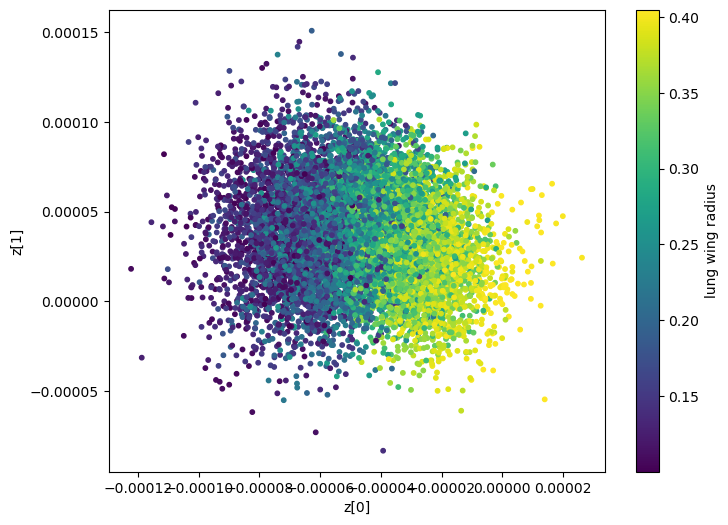

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=radii, s =10)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar(label="lung wing radius")
plt.show()

In [ ]:
# Perform t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2)
latent_space_2d = tsne.fit_transform(z_mean) # latent data

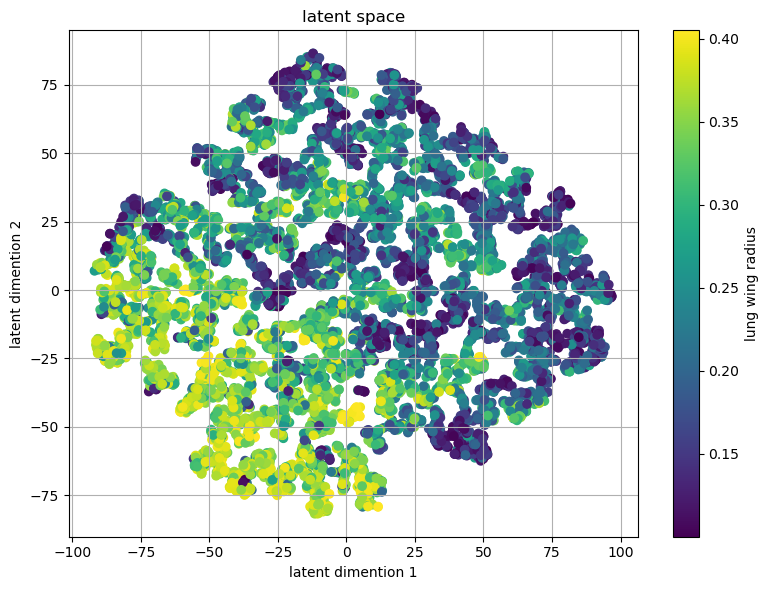

In [27]:
plt.figure(figsize=(8, 6))
plt.title("latent space")
plt.scatter(latent_space_2d[:,0],latent_space_2d[:,1], c=radii)
plt.xlabel("latent dimention 1")
plt.ylabel("latent dimention 2")
plt.colorbar(label="lung wing radius")
plt.grid()
plt.tight_layout()
plt.show()

## Build LSTM

In [35]:
_,_, V_z_all = vae.encoder.predict(V_all)

313/313 [==============================] - 1s 2ms/step


In [45]:
nseg = 3

X = [V_z_all[n : n + nseg, :] for n in range(V_z_all.shape[0] - nseg + 1)]
X = np.array(X)

Y = np.array(V_z_all[nseg - 1 :])

In [46]:
print(X.shape, Y.shape)

(9998, 3, 4) (9998, 4)


In [47]:
def lstm_split(input_shape, nseg, v_shape):
    def Slice(s):
        def func(x):
            return x[:, s, :]

        return func

    # define shared layers
    dense = Dense(v_shape, activation="relu")
    inputs = Input(shape=input_shape)
    con_list = []
    for s in range(nseg):
        # slicing x
        x = Lambda(Slice(s))(inputs)
        # shared layers
        x = dense(x)
        con_list.append(x)

    # concat and reshape for LSTM
    x = Concatenate(axis=1)(con_list)
    x = Reshape((nseg, int(x.shape[1] / nseg)))(x)

    x = LSTM(v_shape)(x)
    x = Activation("softmax")(x)

    return Model(inputs, x)

In [48]:
lstm = lstm_split(
    input_shape=(nseg, latent_dim), nseg=nseg, v_shape=V_z_all.shape[1]
)
lstm.compile(optimizer="adam", loss="binary_crossentropy")
print(lstm.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 3, 4)]       0           []                               
                                                                                                  
 lambda_9 (Lambda)              (None, 4)            0           ['input_5[0][0]']                
                                                                                                  
 lambda_10 (Lambda)             (None, 4)            0           ['input_5[0][0]']                
                                                                                                  
 lambda_11 (Lambda)             (None, 4)            0           ['input_5[0][0]']                
                                                                                            

2023-11-01 13:56:41.342309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-01 13:56:41.343453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-01 13:56:41.344335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [50]:
X_lstm_train, X_lstm_test, Y_lstm_train, Y_lstm_test = train_test_split(
    X, Y, test_size=0.05, shuffle=True, random_state=52
)

In [51]:
epochs = 100
batch_size = 8

history = lstm.fit(
    X_lstm_train,
    Y_lstm_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_lstm_test, Y_lstm_test),
)

Epoch 1/100


2023-11-01 13:56:57.979138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-01 13:56:57.980628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-01 13:56:57.981680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1178/1188 [============================>.] - ETA: 0s - loss: 0.4151

2023-11-01 13:57:05.660126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-01 13:57:05.661651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-01 13:57:05.662718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1188/1188 [==============================] - 8s 5ms/step - loss: 0.4141 - val_loss: 0.2091
Epoch 2/100
1188/1188 [==============================] - 6s 5ms/step - loss: 0.1987 - val_loss: 0.1194
Epoch 3/100
1188/1188 [==============================] - 6s 5ms/step - loss: 0.1337 - val_loss: 0.0871
Epoch 4/100
1188/1188 [==============================] - 6s 5ms/step - loss: 0.1130 - val_loss: 0.0754
Epoch 5/100
1188/1188 [==============================] - 6s 5ms/step - loss: 0.1039 - val_loss: 0.0691
Epoch 6/100
1188/1188 [==============================] - 6s 5ms/step - loss: 0.0987 - val_loss: 0.0654
Epoch 7/100
1188/1188 [==============================] - 6s 5ms/step - loss: 0.0953 - val_loss: 0.0629
Epoch 8/100
1188/1188 [==============================] - 6s 5ms/step - loss: 0.0930 - val_loss: 0.0612
Epoch 9/100
1188/1188 [==============================] - 6s 5ms/step - loss: 0.0914 - val_loss: 0.0599
Epoch 10/100
1188/1188 [==============================] - 6s 5ms/step - loss: 0.0901 

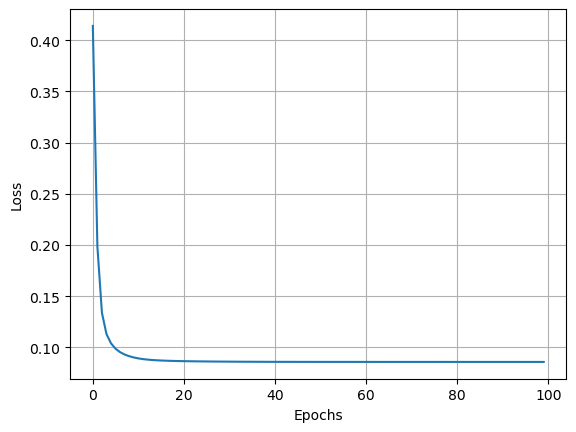

In [52]:
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [53]:
pred = lstm.predict(X_lstm_test)

2023-11-01 14:07:57.361972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-01 14:07:57.363487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-01 14:07:57.364511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 3ms/step


In [55]:
pred

array([[0.17528611, 0.17526603, 0.47391358, 0.17553422],
       [0.36490908, 0.13498652, 0.13498679, 0.3651176 ],
       [0.17586942, 0.17587107, 0.17587148, 0.47238803],
       ...,
       [0.4729012 , 0.17742236, 0.17483829, 0.17483816],
       [0.3650387 , 0.13495883, 0.3650433 , 0.13495913],
       [0.22696199, 0.16660011, 0.4398375 , 0.16660042]], dtype=float32)

In [58]:
vae.decoder.predict(pred).shape

16/16 [==============================] - 0s 3ms/step


(500, 192)

16/16 [==============================] - 0s 3ms/step


<StemContainer object of 3 artists>

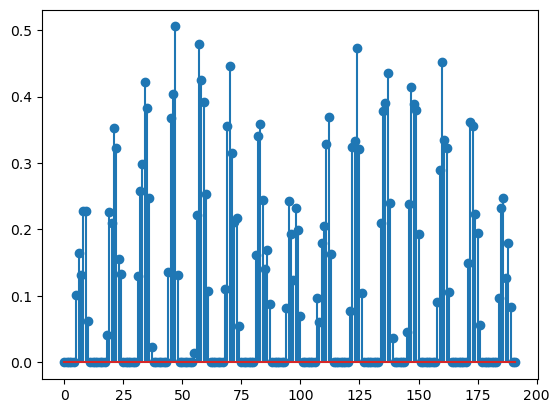

In [59]:
plt.stem(vae.decoder.predict(pred)[10,:])

In [63]:
vae.decoder.predict(Y_lstm_test)-vae.decoder.predict(pred)[10,:]

16/16 [==============================] - 0s 2ms/step


array([[0.        , 0.        , 0.        , ..., 0.00038487, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00271609, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00070832, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00105567, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00073605, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00102384, 0.        ,
        0.        ]], dtype=float32)